In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

# Loading of data

In [3]:
data_dir = Path("data")

In [4]:
dtype = {
    "store_nbr": "category",
    "family": "category",
    "sales": "float32",
    "onpromotion": "uint32",
    "id": "uint32"
}

In [5]:
store_sales = pd.read_csv(
    data_dir / "train.csv",
    usecols=["store_nbr", "family", "date", "sales", "onpromotion"],
    dtype=dtype,
    index_col="date",
    parse_dates=["date"],
    infer_datetime_format=True
)

In [6]:
store_sales = store_sales.to_period("D")  # Timestamp to period by day

In [7]:
store_sales = store_sales.set_index(["store_nbr", "family"], append=True)

In [8]:
average_sales = store_sales.groupby("date").mean()["sales"]

# Plotting options

In [14]:
scatter_kws = dict(
    color="0.75",  # Blue color for straight lines
    style=".-",  # Dots connected by lines
    markeredgecolor="0.25",  # Gray dot contour
    markerfacecolor="0.25",  # Gray dots
    legend=False,  # Ignore legend
    alpha=0.7  # Alpha of dots
)

# Moving average

In [10]:
window_size = 365  # Annual moving average

In [11]:
trend = average_sales.rolling(
    window=window_size,
    center=True,
    min_periods=window_size // 2
).mean()

Text(0.5, 1.0, 'Average sales trend')

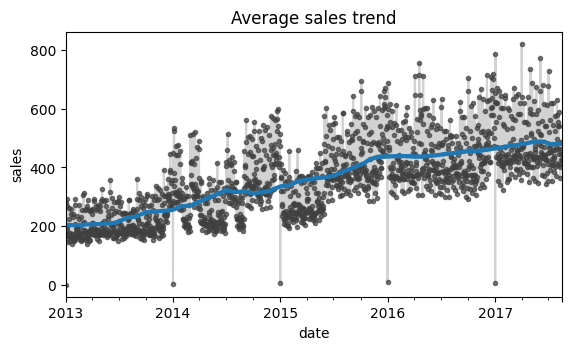

In [18]:
ax = average_sales.plot(**scatter_kws)
ax = trend.plot(ax=ax, linewidth=3)

ax.set_aspect("equal")  # Avoid missinterpretation of data due to x and y scales
ax.set_ylabel("sales")
ax.set_title("Average sales trend")

# Modeling

The trend of the average sales appears to have a linear behaviour, thus it will be modelled using a linear regression model.

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [20]:
# Get time dummies
dp = DeterministicProcess(
    index=average_sales.index,
    order=1,
    drop=True  # Drop term if the produce collinearity issues
)

In [21]:
X = dp.in_sample()

In [22]:
X.head()

,trend
date,
2013-01-01,1.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,4.0
2013-01-05,5.0


In [28]:
y = average_sales.copy()

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
model = LinearRegression()

In [29]:
model.fit(X, y)

LinearRegression()

In [30]:
X_forecast = dp.out_of_sample(365)  # Forecast next year

In [31]:
y_pred = pd.Series(model.predict(X), index=X.index)

In [32]:
y_forecast = pd.Series(model.predict(X_forecast), index=X_forecast.index)

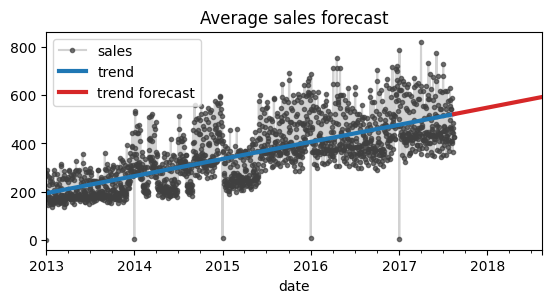

In [35]:
ax = y.plot(**scatter_kws)
ax = y_pred.plot(ax=ax, linewidth=3, label="trend")
ax = y_forecast.plot(ax=ax, linewidth=3, label="trend forecast", color="C3")

ax.set_aspect("equal")
ax.set_title("Average sales forecast")
ax.legend();